# DO NOT RERUN or change yet. still working on this. 

# Entropy from ancestry coefficients (q) and genotype probabilities (gprob)  

Does everything to run entropy and creates slurm files to submit

Goal is 4 chains k=2-X (you decide)

**Create conda env just for entropy**  
`conda create -n entropy`  
`conda activate entropy`  
`conda install popgen-entropy`  

In [5]:
import sys
import ipyparallel as ipp
import os
from os import environ
import gzip
import warnings
import pandas as pd
import numpy as np
import scipy as sp
import glob
import re
import random

In [6]:
root = "/data/gpfs/assoc/denovo/tfaske/rabbit/full/REDO/"

In [7]:
cd $root

/data/gpfs/assoc/denovo/tfaske/rabbit/full/REDO


### Create mgpl & pntest files with associated dir 

In [8]:
!mkdir entropy

mkdir: cannot create directory ‘entropy’: File exists


In [9]:
ent_dir =os.path.join(root,'entropy')
assert ent_dir

In [10]:
cd $ent_dir

/data/gpfs/assoc/denovo/tfaske/rabbit/full/REDO/entropy


#### copy good_snps.recode.vcf.gz from filtering

In [11]:
!cp ../SNPcall/filtering/good_snps.recode.vcf.gz .

In [12]:
!gunzip 'good_snps.recode.vcf.gz'

In [13]:
vcf = 'good_snps.recode.vcf'
vcf

'good_snps.recode.vcf'

In [14]:
perl_mpgl = '/data/gpfs/assoc/denovo/src/perl_scripts/vcf2mpgl_universal.pl'
perl_mean = '/data/gpfs/assoc/denovo/src/perl_scripts/gl2genest_universal.pl'

In [15]:
!perl $perl_mpgl $vcf

Number of loci: 22917; number of individuals 586


In [16]:
mpgl = 'good_snps.recode.mpgl'

In [17]:
!perl $perl_mean $mpgl mean

### Create ldak files in R

In [18]:
%load_ext rpy2.ipython

In [25]:
%%R
require(readr)
require(MASS)
require(LEA)
require(ggplot2)
#library(ggsci)

source('/data/gpfs/assoc/denovo/src/R/Imports.R')

setwd('/data/gpfs/assoc/denovo/tfaske/rabbit/full/REDO/entropy')

R[write to console]: Loading required package: LEA



In [20]:
%%R
#create Pop_ID file 

indv<-read.table("../SNPcall/filtering/good_snps.recode.vcf.gz.012.indv",sep="\t")

Pop_ID <- data.frame(Pop=rep(NA,times=nrow(indv)),
                     ID=NA,
                     All=NA)
for (i in 1:nrow(indv)){
    name_list <-unlist(strsplit(as.character(indv$V1[i]),"_"))
    Pop_ID$Pop[i] <- name_list[2]
    Pop_ID$ID[i] <- name_list[3]
    Pop_ID$All[i] <- as.character(indv$V1[i])
}
print(head(Pop_ID))
print(length(unique(Pop_ID$Pop)))
write.csv(Pop_ID,'Pop_ID.csv',row.names=F)

  Pop ID      All
1  AH 10 EN_AH_10
2  AH 11 EN_AH_11
3  AH 12 EN_AH_12
4  AH 13 EN_AH_13
5  AH 14 EN_AH_14
6  AH 15 EN_AH_15
[1] 75


In [21]:
%%R
g <- read.table("pntest_mean_good_snps.recode.txt", header=F)
dim(g)

[1] 22917   586


In [22]:
%%R
Pop_ID <- read.csv("Pop_ID.csv")
pca_df <- PCA_entropy(t(g))

    PC1     PC2     PC3     PC4     PC5 
0.06179 0.04103 0.02717 0.02207 0.01579 


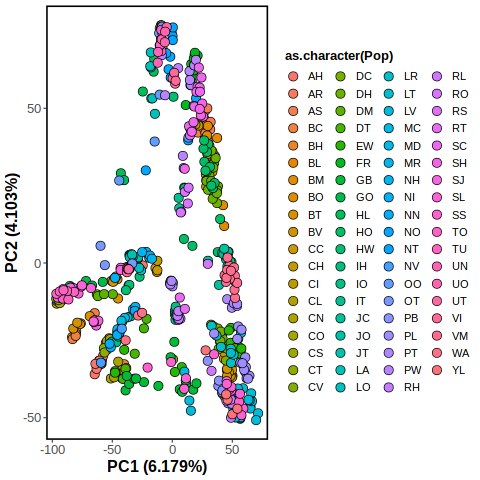

In [27]:
%%R

### check pntest_mean PCA looks okay
pca_df <- cbind(pca_df[,1:10],Pop_ID)


#colors gotten from using hard (force vector) setting: http://medialab.github.io/iwanthue/

ggplot(data = pca_df, aes(x=PC1,y=PC2,fill=as.character(Pop))) +
  geom_point(pch=21,colour='black',size = 4) + 
  xlab(paste("PC",1," (",0.06179*100,"%)",sep="")) + 
  ylab(paste("PC",2," (",0.04103*100,"%)",sep="")) +
  #scale_fill_npg() +
  theme_bw() + 
  theme(#legend.position = 'none',
        axis.text = element_text(size=13),
        axis.title = element_text(size = 16, colour="black",
                                  face = "bold",vjust = 1),
        panel.border = element_rect(size = 1.5, colour = "black"),
        legend.text = element_text(size = 11),
        legend.title = element_text(size = 13, face = "bold"),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank())

In [28]:
%%R
#######################################################################################
                                    #### LDA ####
#######################################################################################

k2<-kmeans(pca_df[,1:5],2,iter.max=10,nstart=10,algorithm="Hartigan-Wong")
k3<-kmeans(pca_df[,1:5],3,iter.max=10,nstart=10,algorithm="Hartigan-Wong")
k4<-kmeans(pca_df[,1:5],4,iter.max=10,nstart=10,algorithm="Hartigan-Wong")
k5<-kmeans(pca_df[,1:5],5,iter.max=10,nstart=10,algorithm="Hartigan-Wong")
k6<-kmeans(pca_df[,1:5],6,iter.max=10,nstart=10,algorithm="Hartigan-Wong")
k7<-kmeans(pca_df[,1:5],7,iter.max=10,nstart=10,algorithm="Hartigan-Wong")
k8<-kmeans(pca_df[,1:5],8,iter.max=10,nstart=10,algorithm="Hartigan-Wong")
k9<-kmeans(pca_df[,1:5],9,iter.max=10,nstart=10,algorithm="Hartigan-Wong")
k10<-kmeans(pca_df[,1:5],10,iter.max=10,nstart=10,algorithm="Hartigan-Wong")
k11<-kmeans(pca_df[,1:5],11,iter.max=10,nstart=10,algorithm="Hartigan-Wong")

ldak2<-lda(x=pca_df[,1:5],grouping=k2$cluster,CV=TRUE)
ldak3<-lda(x=pca_df[,1:5],grouping=k3$cluster,CV=TRUE)
ldak4<-lda(x=pca_df[,1:5],grouping=k4$cluster,CV=TRUE)
ldak5<-lda(x=pca_df[,1:5],grouping=k5$cluster,CV=TRUE)
ldak6<-lda(x=pca_df[,1:5],grouping=k6$cluster,CV=TRUE)
ldak7<-lda(x=pca_df[,1:5],grouping=k7$cluster,CV=TRUE)
ldak8<-lda(x=pca_df[,1:5],grouping=k8$cluster,CV=TRUE)
ldak9<-lda(x=pca_df[,1:5],grouping=k9$cluster,CV=TRUE)
ldak10<-lda(x=pca_df[,1:5],grouping=k10$cluster,CV=TRUE)
ldak11<-lda(x=pca_df[,1:5],grouping=k11$cluster,CV=TRUE)

write.table(round(ldak2$posterior,5),file="ldak2.txt",quote=F,row.names=F,col.names=F)
write.table(round(ldak3$posterior,5),file="ldak3.txt",quote=F,row.names=F,col.names=F)
write.table(round(ldak4$posterior,5),file="ldak4.txt",quote=F,row.names=F,col.names=F)
write.table(round(ldak5$posterior,5),file="ldak5.txt",quote=F,row.names=F,col.names=F)
write.table(round(ldak6$posterior,5),file="ldak6.txt",quote=F,row.names=F,col.names=F)                                      
write.table(round(ldak7$posterior,5),file="ldak7.txt",quote=F,row.names=F,col.names=F)
write.table(round(ldak8$posterior,5),file="ldak8.txt",quote=F,row.names=F,col.names=F)
write.table(round(ldak9$posterior,5),file="ldak9.txt",quote=F,row.names=F,col.names=F)
write.table(round(ldak10$posterior,5),file="ldak10.txt",quote=F,row.names=F,col.names=F)
write.table(round(ldak11$posterior,5),file="ldak11.txt",quote=F,row.names=F,col.names=F)


In [29]:
%%R
######### create entropy header ####

Pop_ID_list <- paste(Pop_ID$Pop,Pop_ID$ID,sep='_')

Header <- data.frame(dims = NA,Pop_ID_list)

dim(g)

df <- t(Header)
dims <- paste(dim(g)[2],dim(g)[1],sep = " ")

df[1,1] <- dims

write.table(df,'entropy_header.txt',sep = " ",na ="",
            quote = FALSE,row.names = FALSE,col.names = FALSE)

In [30]:
!head entropy_header.txt

586 22917                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
AH_10 AH_11 AH_12 AH_13 AH_14 AH_15 AH_1 AH_2 AH_3 AH_4 AH_5 AH_6 AH_7 AH_8 AH_9 AR_2 AR_3 AR_4 AR_5 AR_6 AS_16 AS_17 AS_18 AS_19 AS_20 AS_21 AS_22 AS_23 AS_24 AS_25 AS_26 AS_27 AS_28 AS_29 AS_30 BC_10 BC_11 BC_12 BC_13 BC_1 BC_2 BC_3 BC_4 BC_5 BC_6 BC_7 BC_8 BC_9 BH_1 BH_2 BH_3 BH_4 BH_5 BH_6 BL_1 BL_2 BL_3 BL_4 BL_5 BL_6 BM_16 BM_18 BM_19 BM_20 BM_21 BM_22 BM_23 BM_24 BM_25 BM_26 BM_27 BM_28 BM_29 BM

In [31]:
!cat entropy_header.txt good_snps.recode.mpgl > entropy.mpgl

In [32]:
cd $ent_dir

/data/gpfs/assoc/denovo/tfaske/rabbit/full/REDO/entropy


In [33]:
!mkdir shdir

In [34]:
### select slurm options
account = 'cpu-s5-denovo-0'
partition = 'cpu-core-0'
time = '14-00:00:00' #time limit 4
cpus = 4 #to prevent hammering one node
mem_cpu = 8000
email = 'tfaske@nevada.unr.edu'

#entropy settings
l = 60000
b = 10000
num_k = [2,3,4,5,6,7,8,9]
chains = 4

**Note:** Random seed needs to be created for each chain. Most programs use the clock as the seed, which is typically fine but since the clock on the HPC only goes to minutes and we are running everything at the same time, all the seeds are the same. Giving you the same exact seed. 

In [35]:
def write_entropy_sh(account,partition,time,cpus,mem_cpu,email,l,b,num_k,chains):
    for k in num_k:
        for c in range(1,chains+1):
            jobname = 'k%d_c%d' % (k,c)
            seed = random.randint(1000,9999) #default is clock so messes up if submitted same time 
            with open("shdir/run_entropy_%s.sh" % (jobname), "w") as o:
                o.write("""#!/usr/bin/env bash
#SBATCH --account=%s
#SBATCH --partition=%s
#SBATCH --time=%s
#SBATCH --ntasks 1
#SBATCH --cpus-per-task %d
#SBATCH --mem-per-cpu=%d
#SBATCH --job-name ent_%s
#SBATCH --output output_%s.txt
#SBATCH --mail-type=END
#SBATCH --mail-user=%s\n\n""" % (account,partition,time,cpus,mem_cpu,jobname,jobname,email))
        
                o.write("entropy -i ../entropy.mpgl -o ../entropy_%s.hdf5 -r %d -n 2 -l %d -b %d -t 10 -s 50 -e .01 -k %d -q ../ldak%d.txt -m 1 -w 0"
                        % (jobname,seed,l,b,k,k))
    

In [36]:
write_entropy_sh(account,partition,time,cpus,mem_cpu,email,l,b,num_k,chains)

In [37]:
entShells = !find $ent_dir -name 'run_entropy*.sh'
entShells = entShells.sort()
entShells

['/data/gpfs/assoc/denovo/tfaske/rabbit/full/REDO/entropy/shdir/run_entropy_k2_c1.sh',
 '/data/gpfs/assoc/denovo/tfaske/rabbit/full/REDO/entropy/shdir/run_entropy_k2_c2.sh',
 '/data/gpfs/assoc/denovo/tfaske/rabbit/full/REDO/entropy/shdir/run_entropy_k2_c3.sh',
 '/data/gpfs/assoc/denovo/tfaske/rabbit/full/REDO/entropy/shdir/run_entropy_k2_c4.sh',
 '/data/gpfs/assoc/denovo/tfaske/rabbit/full/REDO/entropy/shdir/run_entropy_k3_c1.sh',
 '/data/gpfs/assoc/denovo/tfaske/rabbit/full/REDO/entropy/shdir/run_entropy_k3_c2.sh',
 '/data/gpfs/assoc/denovo/tfaske/rabbit/full/REDO/entropy/shdir/run_entropy_k3_c3.sh',
 '/data/gpfs/assoc/denovo/tfaske/rabbit/full/REDO/entropy/shdir/run_entropy_k3_c4.sh',
 '/data/gpfs/assoc/denovo/tfaske/rabbit/full/REDO/entropy/shdir/run_entropy_k4_c1.sh',
 '/data/gpfs/assoc/denovo/tfaske/rabbit/full/REDO/entropy/shdir/run_entropy_k4_c2.sh',
 '/data/gpfs/assoc/denovo/tfaske/rabbit/full/REDO/entropy/shdir/run_entropy_k4_c3.sh',
 '/data/gpfs/assoc/denovo/tfaske/rabbit/ful

In [38]:
def write_sbatch_entShells(entShells):
         with open("shdir/sbatch_entropy.sh", "w") as o:
            o.write("""#!/usr/bin/env bash \n""")
            for sh in entShells:
                o.write("""sbatch %s\n""" % (sh))

In [39]:
write_sbatch_entShells(entShells)

# Run all entropy*sh
    cd /data/gpfs/assoc/denovo/tfaske/rabbit/full/REDO/entropy/shdir
    source activate entropy
    bash sbatch_entropy.sh

# Use estpost to get DIC, q, and gprob

In [41]:
np.set_printoptions(precision=8) # increases float print option
#pd.set_option("precision", 8)

In [66]:
cd $ent_dir

/data/gpfs/assoc/denovo/tfaske/rabbit/full/REDO/entropy


In [67]:
hdf5_files = !find . -name '*hdf5'
hdf5_files = hdf5_files.sort()
hdf5_files

['./entropy_k2_c1.hdf5',
 './entropy_k2_c2.hdf5',
 './entropy_k2_c3.hdf5',
 './entropy_k2_c4.hdf5',
 './entropy_k3_c1.hdf5',
 './entropy_k3_c2.hdf5',
 './entropy_k3_c3.hdf5',
 './entropy_k3_c4.hdf5',
 './entropy_k4_c1.hdf5',
 './entropy_k4_c2.hdf5',
 './entropy_k4_c3.hdf5',
 './entropy_k4_c4.hdf5',
 './entropy_k5_c1.hdf5',
 './entropy_k5_c2.hdf5',
 './entropy_k5_c3.hdf5',
 './entropy_k5_c4.hdf5',
 './entropy_k6_c1.hdf5',
 './entropy_k6_c2.hdf5',
 './entropy_k6_c3.hdf5',
 './entropy_k6_c4.hdf5',
 './entropy_k7_c1.hdf5',
 './entropy_k7_c2.hdf5',
 './entropy_k7_c3.hdf5',
 './entropy_k7_c4.hdf5',
 './entropy_k8_c1.hdf5',
 './entropy_k8_c2.hdf5',
 './entropy_k8_c3.hdf5',
 './entropy_k8_c4.hdf5',
 './entropy_k9_c1.hdf5',
 './entropy_k9_c2.hdf5',
 './entropy_k9_c3.hdf5',
 './entropy_k9_c4.hdf5']

In [68]:
estpost = '/data/gpfs/home/tfaske/g/anaconda3/envs/entropy/bin/estpost.entropy'

In [69]:
#make DIC
for i in range(0,len(hdf5_files)):
    f = hdf5_files[i]
    k = f.split('_')[1] #set this 
    c = f.split('_')[2].split('.hdf5')[0]
    #print(k,c)
    dic = "DIC_%s_%s.txt" % (k,c)
    !$estpost $f -s 3 -p deviance > $dic

In [70]:
dic_files = !find . -name 'DIC*'
dic_files

['./DIC_k2_c4.txt',
 './DIC_k7_c2.txt',
 './DIC_k2_c1.txt',
 './DIC_k6_c1.txt',
 './DIC_k3_c2.txt',
 './DIC_k4_c4.txt',
 './DIC_k4_c2.txt',
 './DIC_k7_c1.txt',
 './DIC_k7_c4.txt',
 './DIC_k5_c2.txt',
 './DIC_k6_c2.txt',
 './DIC_k4_c3.txt',
 './DIC_k7_c3.txt',
 './DIC_k3_c1.txt',
 './DIC_k2_c2.txt',
 './DIC_k5_c4.txt',
 './DIC_k8_c4.txt',
 './DIC_k6_c3.txt',
 './DIC_k8_c3.txt',
 './DIC_k8_c1.txt',
 './DIC_k4_c1.txt',
 './DIC_k2_c3.txt',
 './DIC_k8_c2.txt',
 './DIC_k9_c3.txt',
 './DIC_k9_c2.txt',
 './DIC_k6_c4.txt',
 './DIC_k3_c4.txt',
 './DIC_k9_c1.txt',
 './DIC_k5_c1.txt',
 './DIC_k3_c3.txt',
 './DIC_k5_c3.txt',
 './DIC_k9_c4.txt']

In [71]:
for d in dic_files:
    !cat $d
    print('\n')

file = ./entropy_k2_c4.hdf5
parameter dimensions for deviance: samples = 5000, chains = 1
Model deviance: 21147920.75
Effective number of parameters: 10087841.07
Model DIC: 31235761.82


file = ./entropy_k7_c2.hdf5
parameter dimensions for deviance: samples = 5000, chains = 1
Model deviance: 18628486.61
Effective number of parameters: 22611261.39
Model DIC: 41239748.01


file = ./entropy_k2_c1.hdf5
parameter dimensions for deviance: samples = 5000, chains = 1
Model deviance: 21147981.81
Effective number of parameters: 10258025.55
Model DIC: 31406007.37


file = ./entropy_k6_c1.hdf5
parameter dimensions for deviance: samples = 5000, chains = 1
Model deviance: 18833533.44
Effective number of parameters: 17686708.26
Model DIC: 36520241.70


file = ./entropy_k3_c2.hdf5
parameter dimensions for deviance: samples = 5000, chains = 1
Model deviance: 20067827.80
Effective number of parameters: 13406186.27
Model DIC: 33474014.06


file = ./entropy_k4_c4.hdf5
parameter dimensions for deviance: sa

In [72]:
dic_list = []
for d in dic_files:
    k = d.split('_k')[1].split('_')[0] #set this 
    c = d.split('_c')[1].split('.txt')[0]
    #print(k,c)
    
    dic = !grep 'DIC' $d
    dic = float(re.search('(\d+.\d+)',str(dic)).group(0))
    #print(dic)
    
    dic_list.append([k,dic,c])
dic_df = pd.DataFrame(dic_list,columns=['k','DIC','chain'])
dic_df.head()

,k,DIC,chain
0,2,31235761.82,4
1,7,41239748.01,2
2,2,31406007.37,1
3,6,36520241.70,1
4,3,33474014.06,2


In [73]:
dic_df.to_csv('dic_list.csv')

In [74]:
dic_sum = dic_df.groupby('k').describe().DIC

In [75]:
dic_sum.sort_values('mean')

,count,mean,std,min,25%,50%,75%,max
k,,,,,,,,
2,4.0,3.151842e+07,2.548149e+05,3.123576e+07,3.136345e+07,3.150597e+07,3.166094e+07,3.182600e+07
3,4.0,3.360282e+07,6.363335e+05,3.314580e+07,3.322869e+07,3.336517e+07,3.373930e+07,3.453515e+07
5,4.0,3.405831e+07,3.975393e+05,3.351859e+07,3.392628e+07,3.412418e+07,3.425621e+07,3.446629e+07
4,4.0,3.508518e+07,5.949308e+05,3.428080e+07,3.484758e+07,3.519619e+07,3.543380e+07,3.566755e+07
6,4.0,3.681168e+07,9.056206e+05,3.565871e+07,3.630486e+07,3.700765e+07,3.751447e+07,3.757270e+07
7,4.0,3.823035e+07,2.058698e+06,3.677734e+07,3.697612e+07,3.745215e+07,3.870638e+07,4.123975e+07
8,4.0,1.875255e+08,9.295616e+07,8.361735e+07,1.338960e+08,1.823276e+08,2.359571e+08,3.018293e+08
9,4.0,4.997376e+08,2.975772e+08,1.452553e+08,3.501194e+08,4.987275e+08,6.483458e+08,8.562403e+08


In [76]:
dic_sum.to_csv('dic_sum.csv')

### Get gprob and q for each k, and mcmc metrics

In [52]:
# ancestry coeffecients 
!$estpost *k2*.hdf5 -p q -s 0 -o q2.txt

!$estpost *k3*.hdf5 -p q -s 0 -o q3.txt

!$estpost *k4*.hdf5 -p q -s 0 -o q4.txt

!$estpost *k5*.hdf5 -p q -s 0 -o q5.txt

!$estpost *k6*.hdf5 -p q -s 0 -o q6.txt

#!$estpost *k7*.hdf5 -p q -s 0 -o q7.txt

#!$estpost *k8*.hdf5 -p q -s 0 -o q8.txt

#!$estpost *k9*.hdf5 -p q -s 0 -o q9.txt

file = entropy_k2_c1.hdf5
file = entropy_k2_c2.hdf5
file = entropy_k2_c3.hdf5
file = entropy_k2_c4.hdf5
parameter dimensions for q: ind = 586, populations = 2, samples = 5000, chains = 4
file = entropy_k3_c1.hdf5
file = entropy_k3_c2.hdf5
file = entropy_k3_c3.hdf5
file = entropy_k3_c4.hdf5
parameter dimensions for q: ind = 586, populations = 3, samples = 5000, chains = 4
file = entropy_k4_c1.hdf5
file = entropy_k4_c2.hdf5
file = entropy_k4_c3.hdf5
file = entropy_k4_c4.hdf5
parameter dimensions for q: ind = 586, populations = 4, samples = 5000, chains = 4
file = entropy_k5_c1.hdf5
file = entropy_k5_c2.hdf5
file = entropy_k5_c3.hdf5
file = entropy_k5_c4.hdf5
parameter dimensions for q: ind = 586, populations = 5, samples = 5000, chains = 4
file = entropy_k6_c1.hdf5
file = entropy_k6_c2.hdf5
file = entropy_k6_c3.hdf5
file = entropy_k6_c4.hdf5
parameter dimensions for q: ind = 586, populations = 6, samples = 5000, chains = 4


In [53]:
#MCMC diagnostics
!$estpost *k2*.hdf5 -p q -s 4 -o MCMC_k2.txt

!$estpost *k3*.hdf5 -p q -s 4 -o MCMC_k3.txt

!$estpost *k4*.hdf5 -p q -s 4 -o MCMC_k4.txt

!$estpost *k5*.hdf5 -p q -s 4 -o MCMC_k5.txt

!$estpost *k6*.hdf5 -p q -s 4 -o MCMC_k6.txt

#!$estpost *k7*.hdf5 -p q -s 4 -o MCMC_k7.txt

#!$estpost *k8*.hdf5 -p q -s 4 -o MCMC_k8.txt

#!$estpost *k9*.hdf5 -p q -s 4 -o MCMC_k9.txt

file = entropy_k2_c1.hdf5
file = entropy_k2_c2.hdf5
file = entropy_k2_c3.hdf5
file = entropy_k2_c4.hdf5
parameter dimensions for q: ind = 586, populations = 2, samples = 5000, chains = 4
file = entropy_k3_c1.hdf5
file = entropy_k3_c2.hdf5
file = entropy_k3_c3.hdf5
file = entropy_k3_c4.hdf5
parameter dimensions for q: ind = 586, populations = 3, samples = 5000, chains = 4
file = entropy_k4_c1.hdf5
file = entropy_k4_c2.hdf5
file = entropy_k4_c3.hdf5
file = entropy_k4_c4.hdf5
parameter dimensions for q: ind = 586, populations = 4, samples = 5000, chains = 4
file = entropy_k5_c1.hdf5
file = entropy_k5_c2.hdf5
file = entropy_k5_c3.hdf5
file = entropy_k5_c4.hdf5
parameter dimensions for q: ind = 586, populations = 5, samples = 5000, chains = 4
file = entropy_k6_c1.hdf5
file = entropy_k6_c2.hdf5
file = entropy_k6_c3.hdf5
file = entropy_k6_c4.hdf5
parameter dimensions for q: ind = 586, populations = 6, samples = 5000, chains = 4


### make slurm script to make gprob file

    use all k and chains to make gprob

In [54]:
cd $ent_dir

/data/gpfs/assoc/denovo/tfaske/rabbit/full/REDO/entropy


In [55]:
### select slurm options
account = 'cpu-s5-denovo-0'
partition = 'cpu-core-0'
time = '1-00:00:00' #time limit 4
cpus = 2 #to prevent hammering one node
mem_cpu = 6000
email = 'tfaske@nevada.unr.edu'

### select k 
num_k = [2,3,4,5,6]

In [56]:
def write_gprob_k_sh(account,partition,time,cpus,mem_cpu,email,estpost,num_k):
    for k in num_k:
        with open("shdir/run_gprob_k%d.sh" % (k), "w") as o:
            o.write("""#!/usr/bin/env bash
#SBATCH --account=%s
#SBATCH --partition=%s
#SBATCH --time=%s
#SBATCH --ntasks 1
#SBATCH --cpus-per-task %d
#SBATCH --mem-per-cpu=%d
#SBATCH --job-name gprob_k%d
#SBATCH --output output_gprob_k%d.txt
#SBATCH --mail-type=END
#SBATCH --mail-user=%s\n\n""" % (account,partition,time,cpus,mem_cpu,k,k,email))
        
            o.write("%s ../*k%d*.hdf5 -p gprob -s 0 -o ../gprob%d.txt" % (estpost,k,k))

In [57]:
write_gprob_k_sh(account,partition,time,cpus,mem_cpu,email,estpost,num_k)

In [58]:
gprobShells = !find $ent_dir -name 'run_gprob*.sh'
gprobShells = gprobShells.sort()
gprobShells

['/data/gpfs/assoc/denovo/tfaske/rabbit/full/REDO/entropy/shdir/run_gprob_k2.sh',
 '/data/gpfs/assoc/denovo/tfaske/rabbit/full/REDO/entropy/shdir/run_gprob_k3.sh',
 '/data/gpfs/assoc/denovo/tfaske/rabbit/full/REDO/entropy/shdir/run_gprob_k4.sh',
 '/data/gpfs/assoc/denovo/tfaske/rabbit/full/REDO/entropy/shdir/run_gprob_k5.sh',
 '/data/gpfs/assoc/denovo/tfaske/rabbit/full/REDO/entropy/shdir/run_gprob_k6.sh']

In [59]:
def write_sbatch_gprobShells(gprobShells):
    with open("shdir/sbatch_gprob.sh", "w") as o:
        o.write("""#!/usr/bin/env bash \n""")
        for sh in gprobShells:
            o.write("""sbatch %s\n""" % (sh))

In [60]:
write_sbatch_gprobShells(gprobShells)

### gprob all 

select only the ks you want. Will not work on ~7 ks with all the chains. It dies. 

k = 2,3,4,5,6

In [61]:
hdf5_files = []
num_k = [2,3,4,5,6]
num_c = 4
for k in num_k:
    for c in range(1,num_c+1):
        f = '../entropy_k' + str(k) + '_c' + str(c) + '.hdf5'
        hdf5_files.append(f)
hdf5_files

['../entropy_k2_c1.hdf5',
 '../entropy_k2_c2.hdf5',
 '../entropy_k2_c3.hdf5',
 '../entropy_k2_c4.hdf5',
 '../entropy_k3_c1.hdf5',
 '../entropy_k3_c2.hdf5',
 '../entropy_k3_c3.hdf5',
 '../entropy_k3_c4.hdf5',
 '../entropy_k4_c1.hdf5',
 '../entropy_k4_c2.hdf5',
 '../entropy_k4_c3.hdf5',
 '../entropy_k4_c4.hdf5',
 '../entropy_k5_c1.hdf5',
 '../entropy_k5_c2.hdf5',
 '../entropy_k5_c3.hdf5',
 '../entropy_k5_c4.hdf5',
 '../entropy_k6_c1.hdf5',
 '../entropy_k6_c2.hdf5',
 '../entropy_k6_c3.hdf5',
 '../entropy_k6_c4.hdf5']

In [62]:
gprob_cmd = estpost + ' ' + ' '.join(hdf5_files) + ' -p gprob -s 0 -o ../gprobAll.txt'
gprob_cmd

'/data/gpfs/home/tfaske/g/anaconda3/envs/entropy/bin/estpost.entropy ../entropy_k2_c1.hdf5 ../entropy_k2_c2.hdf5 ../entropy_k2_c3.hdf5 ../entropy_k2_c4.hdf5 ../entropy_k3_c1.hdf5 ../entropy_k3_c2.hdf5 ../entropy_k3_c3.hdf5 ../entropy_k3_c4.hdf5 ../entropy_k4_c1.hdf5 ../entropy_k4_c2.hdf5 ../entropy_k4_c3.hdf5 ../entropy_k4_c4.hdf5 ../entropy_k5_c1.hdf5 ../entropy_k5_c2.hdf5 ../entropy_k5_c3.hdf5 ../entropy_k5_c4.hdf5 ../entropy_k6_c1.hdf5 ../entropy_k6_c2.hdf5 ../entropy_k6_c3.hdf5 ../entropy_k6_c4.hdf5 -p gprob -s 0 -o ../gprobAll.txt'

In [63]:
### select slurm options
account = 'cpu-s5-denovo-0'
partition = 'cpu-core-0'
time = '1-00:00:00' #time limit 4
cpus = 1 #to prevent hammering one node
mem_cpu = 100000
email = 'tfaske@nevada.unr.edu'

In [64]:
def write_gprob_all_sh(account,partition,time,cpus,mem_cpu,email,estpost,gprob_cmd):
        with open("shdir/run_gprobAll.sh", "w") as o:
            o.write("""#!/usr/bin/env bash
#SBATCH --account=%s
#SBATCH --partition=%s
#SBATCH --time=%s
#SBATCH --ntasks 1
#SBATCH --cpus-per-task %d
#SBATCH --mem-per-cpu=%d
#SBATCH --job-name gprobAll
#SBATCH --output output_gprobAll.txt
#SBATCH --mail-type=END
#SBATCH --mail-user=%s

%s""" % (account,partition,time,cpus,mem_cpu,email,gprob_cmd))

In [65]:
write_gprob_all_sh(account,partition,time,cpus,mem_cpu,email,estpost,gprob_cmd)

## Run gprob sh 

    cd /data/gpfs/assoc/denovo/PHHA/entropy
    source activate entropy
    sbatch run_gprob.sh